In [4]:
import random
import math
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [5]:
def random_sine(samples=50, max_amp=1, min_amp=0, max_freq=5, min_freq=0.2, freq_chaos=0.3, amp_chaos=0.1):
  phase = random.uniform(0, math.pi * 2)
  amp = random.uniform(min_amp, max_amp)
  offset = random.uniform(1-amp, amp-1)
  freq = random.uniform(min_freq, max_freq)
  phase_incr = 2 * freq * math.pi / samples
  output = []

  for _ in range(samples):
    phase += phase_incr
    output.append(math.sin(phase) * amp + offset)
    if random.random() < amp_chaos:
      amp = random.uniform(min_amp, max_amp)
      offset = random.uniform(1-amp, amp-1)
    if random.random() < freq_chaos:
      freq = random.uniform(min_freq, max_freq)
      phase_incr = 2 * freq * math.pi / samples

  return output

In [6]:
def random_nums(samples=50):
  return [random.random() for _ in range(samples)]

In [7]:
def permute_signal(signal, size_reduction = 3, max_pad = 5):
  # remove some points
  new_signal = list(signal)

  for i in range(size_reduction):
    point = random.randint(0, len(new_signal) - 1)
    del new_signal[point]

  # add interpolations
  for i in range(size_reduction):
    point = random.randint(1, len(new_signal) - 1)
    interp = (new_signal[point - 1] + new_signal[point]) / 2
    new_signal.insert(point, interp)

  # add noise
  for i in range(len(new_signal)):
    new_signal[i] += random.uniform(-0.05, 0.05)

  # add some zero padding in the beginning
  pad_num = random.randint(0, max_pad)
  padding = [0 for _ in range(pad_num)]
  new_signal = padding + new_signal[:len(new_signal) - pad_num]

  return new_signal
    

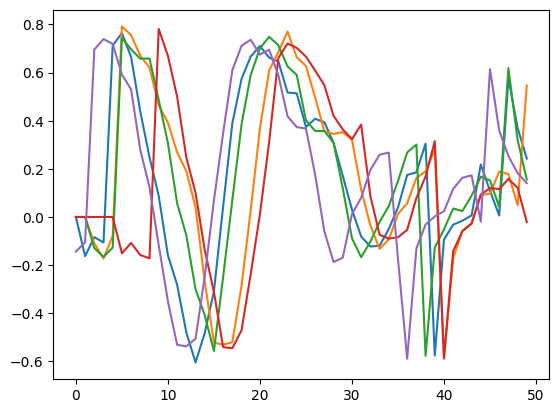

In [8]:
sequence = random_sine()
for _ in range(5):
  plt.plot(permute_signal(sequence))

In [9]:
def generate_data(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y


# MODEL

In [55]:
class LSTMMemory(torch.nn.Module):

  def __init__(self, hidden_size, input_size=1, output_size=1):
    super().__init__()
    self._scaler = StandardScaler()
    self._hidden_state = None
    self.lstm = torch.nn.LSTM(
        input_size = input_size,
        hidden_size = hidden_size,
        batch_first = True
    )
    self.linear = torch.nn.Linear(
            in_features=hidden_size,
            out_features=output_size
        )

  def forward(self, x):
    h = self.lstm(x)[0]

    return self.linear(h)

  def forward_live(self, x):
    
    x = torch.tensor(self._scaler.transform(x).reshape((1, 1)).astype(np.float32))
    if self._hidden_state:
      h, self._hidden_state = self.lstm(x, self._hidden_state)
    else:
      h, self._hidden_state = self.lstm(x)

    return self.linear(h)
  
  def reset_live(self):
    self._hidden_state = None

  def fit(self, data):
    self._scaler.fit(data)

  def transform(self, data):
    return self._scaler.transform(data)

  def fit_transform(self, data):
    return self._scaler.fit_transform(data)


# OTHER SETUP

In [11]:
def curve_plot(rows, cols, X, y, prefix=""):
  axs = (plt.figure(constrained_layout=True)
      .subplots(rows, cols, sharex=True, sharey=True))
  
  if rows > 1:
    for i in range(rows):
      if cols > 1:
        for j in range(cols):
          axs[i][j].set(title = f"{prefix}Input {j}, output {i}")
          axs[i][j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[i][j].plot(y[:, :, i].tolist()[0], label=f"output {i}")
      else:
        axs[i].set(title = f"{prefix}Input, output {i}")
        axs[i].plot(X[:, :, 0].tolist()[0], label=f"input")
        axs[i].plot(y[:, :, i].tolist()[0], label=f"output {i}")

  else:
    if cols > 1:
      for j in range(cols):
          axs[j].set(title = f"{prefix}Input {j}, output")
          axs[j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[j].plot(y[:, :, 0].tolist()[0], label=f"output")
    else:
      axs.set(title = f"{prefix}Input, output")
      axs.plot(X.tolist()[0], label=f"input")
      axs.plot(y.tolist()[0], label=f"output")

  print("Blue inputs, orange outputs")
  plt.show()

# TESTING

## Random sine -> permuted random sine

In [12]:
def generate_randnums_permutedsines(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y

Blue inputs, orange outputs


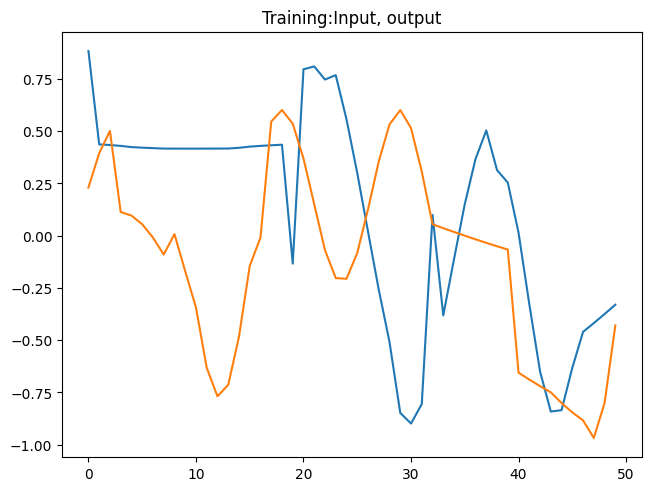

Blue inputs, orange outputs


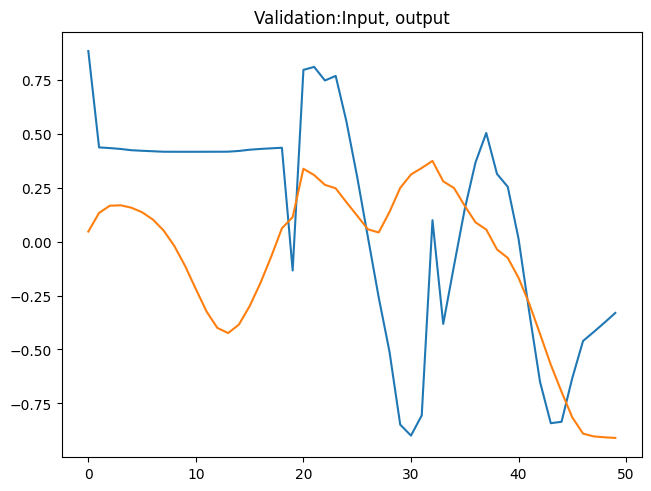

Blue inputs, orange outputs


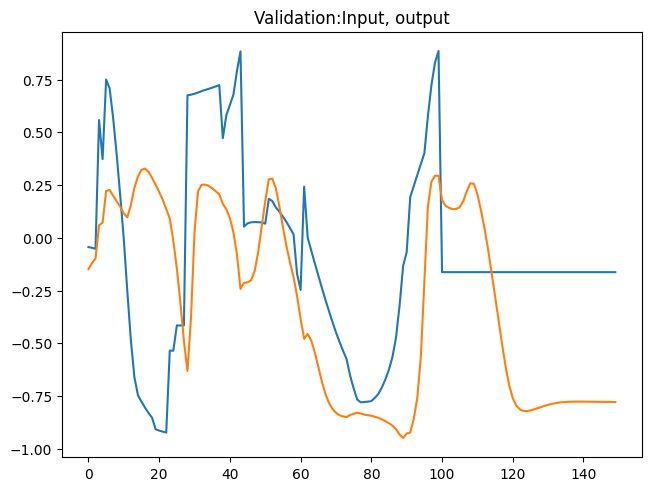

Blue inputs, orange outputs


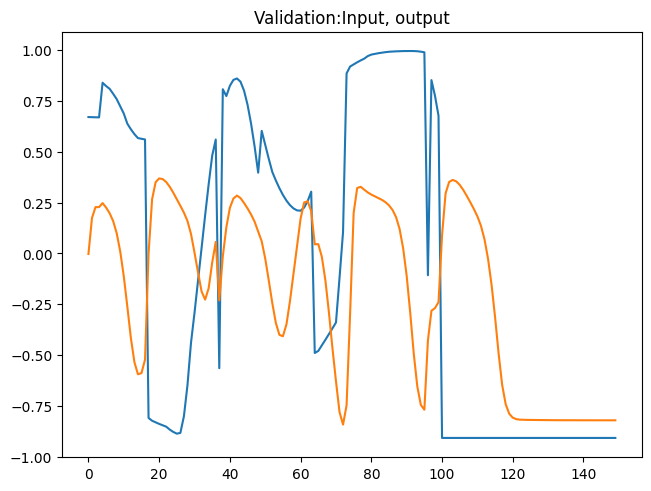

Blue inputs, orange outputs


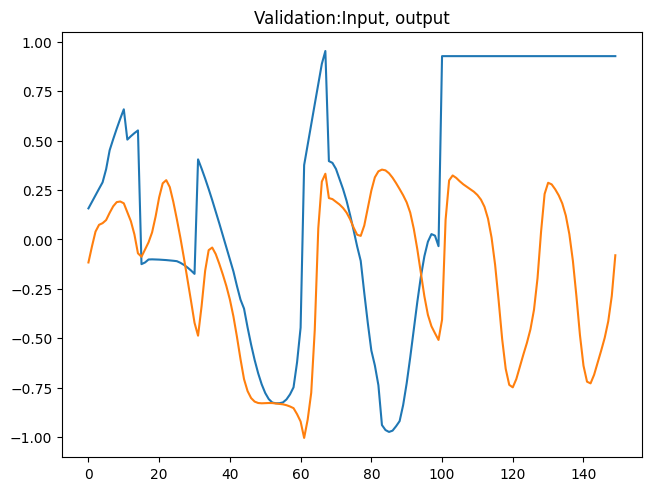

Blue inputs, orange outputs


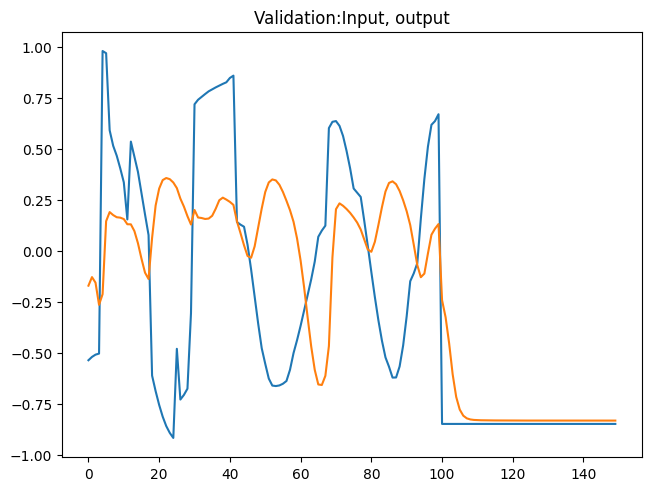

Blue inputs, orange outputs


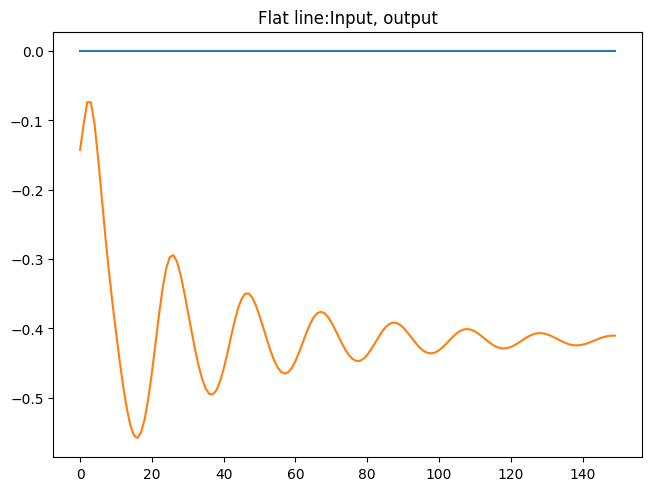

In [13]:
random.seed(45)
torch.manual_seed(42)

model = LSTMMemory(15)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()
x_list = random_sine(50)
X = torch.tensor([x_list for _ in range(6)]).reshape((6, 50, 1))
y_list = [point * 1 for point in random_sine(50)]
curve_plot(1, 1, X, torch.tensor(y_list).reshape(1, 50, 1), "Training:")

for j in range(500):
  optimizer.zero_grad()
  pred = model(X)
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss} but why do I care?")
model.eval()
with torch.no_grad():
  val_y = model(X)
curve_plot(1, 1, X, val_y, "Validation:")

for i in range(4):
  with torch.no_grad():
    finisher = random.uniform(-1, 1)
    test_X = torch.tensor((random_sine(100) + [finisher for _ in range(50)])).reshape((1, 150, 1))
    test_predicted_y = model(test_X)
  curve_plot(1, 1, test_X, test_predicted_y, "Validation:")

with torch.no_grad():
  test_X = torch.tensor([0 for _ in range(150)]).reshape((1, 150, 1)).float()
  test_predicted_y = model(test_X)
curve_plot(1, 1, test_X, test_predicted_y, "Flat line:")



# N random sines -> M random permuted sines

Blue inputs, orange outputs


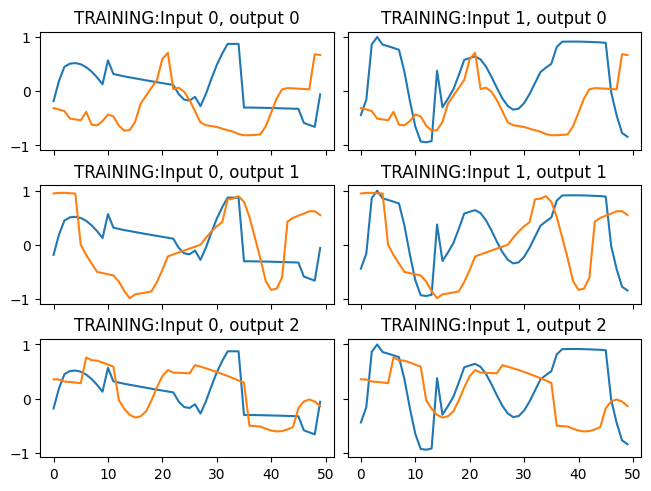

/var/folders/1k/lvlt8xp56tb77wg9bnkzn3gh0000gq/T/ipykernel_30146/3701227651.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curve_plot(outputs, inputs, X, torch.tensor(val_pred_y).reshape((6, 50, outputs)), "VALIDATION:")


Blue inputs, orange outputs


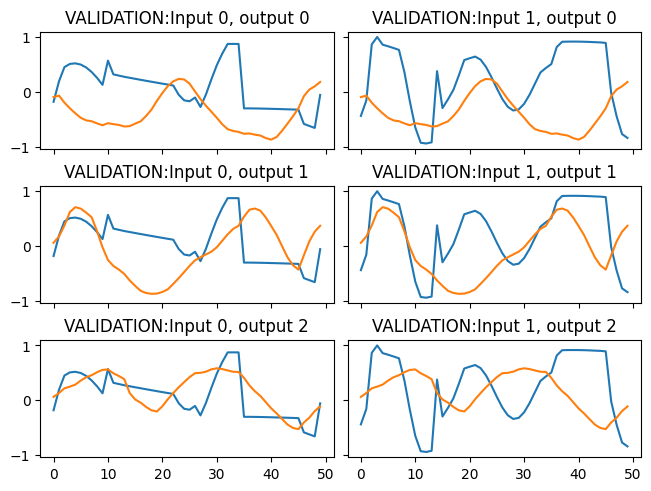

Blue inputs, orange outputs


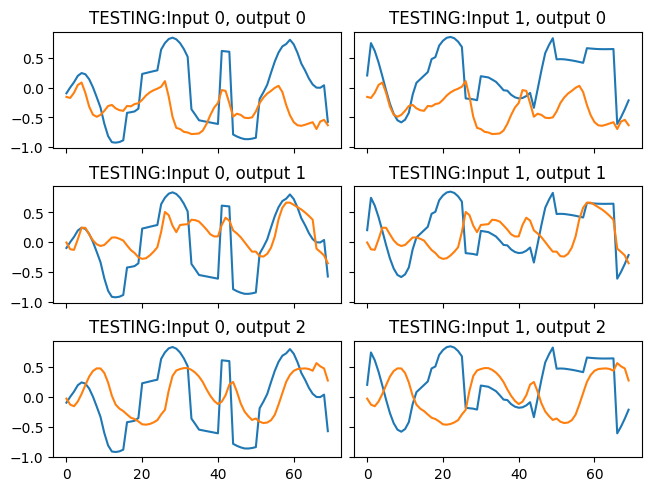

Blue inputs, orange outputs


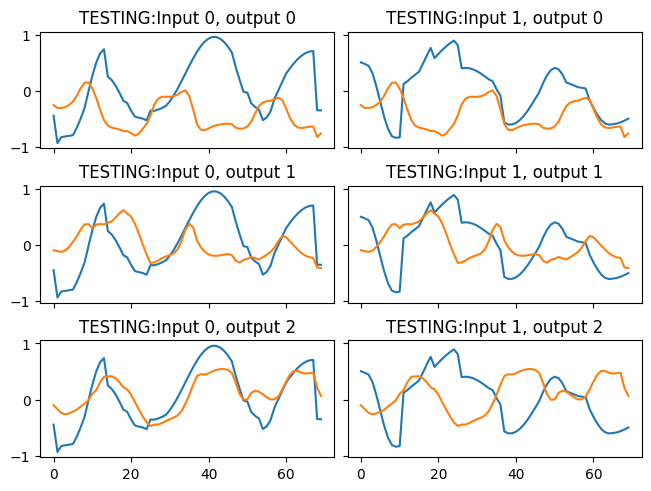

Blue inputs, orange outputs


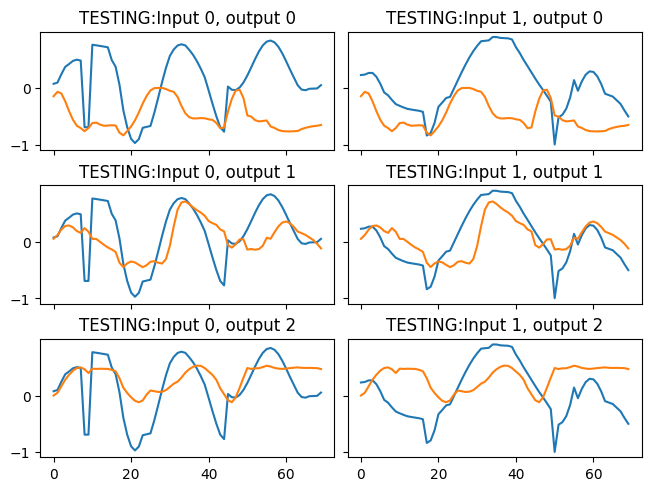

Blue inputs, orange outputs


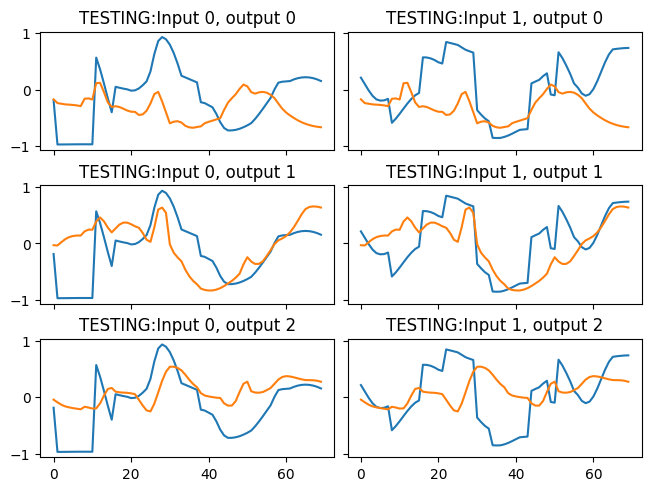

Predicted:  [[[-0.17076264321804047, -0.03144211694598198, -0.04475235193967819], [-0.23693816363811493, -0.03636252507567406, -0.09169051051139832], [-0.2484547346830368, 0.021588729694485664, -0.13412706553936005], [-0.2598856985569, 0.07522603869438171, -0.16365253925323486], [-0.26447594165802, 0.11135882139205933, -0.181025892496109], [-0.26991960406303406, 0.13120190799236298, -0.19433096051216125], [-0.277952641248703, 0.13960057497024536, -0.2052854597568512], [-0.29105469584465027, 0.1390853375196457, -0.21526503562927246], [-0.16026726365089417, 0.21275237202644348, -0.17065253853797913], [-0.15408678352832794, 0.24465784430503845, -0.18387532234191895], [-0.17296597361564636, 0.24212996661663055, -0.20224687457084656], [0.11479532718658447, 0.3874453008174896, -0.19928711652755737], [0.12202206254005432, 0.45936697721481323, -0.11098068952560425], [-0.04428693652153015, 0.39101430773735046, 0.027536150068044662], [-0.2251974493265152, 0.2792966663837433, 0.1449558138847351],

In [68]:
inputs = 2
outputs = 3

random.seed(20)
torch.manual_seed(41)

model_2d_2d = LSTMMemory(15, inputs, outputs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d_2d.parameters(), lr=.02)
model_2d_2d.train()
X_list = list(zip(*[random_sine(50) for _ in range(inputs)]))
X = torch.tensor([X_list for _ in range(6)]).float()
y_list_pure = [random_sine(50) for _ in range(outputs)]

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d_2d(X)
  
  y_list = list(zip(*[permute_signal(y) for y in y_list_pure]))
  y = torch.tensor([y_list for _ in range(6)]).reshape((6, 50, outputs))
  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss}")
model_2d_2d.eval()

true_y = list(zip(*y_list_pure))
curve_plot(outputs, inputs, X, torch.tensor(true_y).reshape((1, 50, outputs)), "TRAINING:")

val_pred_y = model_2d_2d(X)
curve_plot(outputs, inputs, X, torch.tensor(val_pred_y).reshape((6, 50, outputs)), "VALIDATION:")



for i in range(4):
  with torch.no_grad():
    test_X_list = list(zip(*[random_sine(70) for _ in range(inputs)]))
    test_X = torch.tensor(test_X_list).reshape((1, 70, inputs))
    test_predicted_y = model_2d_2d(test_X)
  curve_plot(outputs, inputs, test_X, test_predicted_y, "TESTING:")
print("Predicted: ", test_predicted_y.tolist())

# Time since last note + velocity from Bonk

In [24]:
from sklearn import preprocessing
from math import log

TIMES


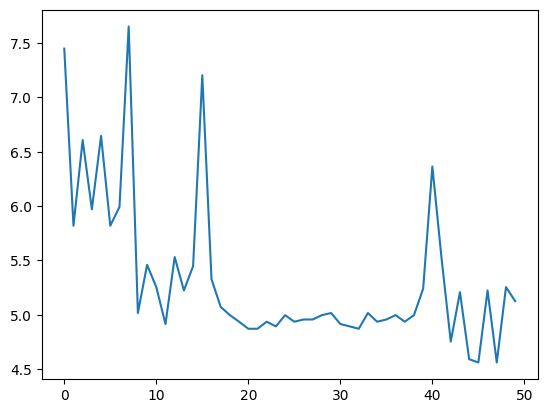

VELS


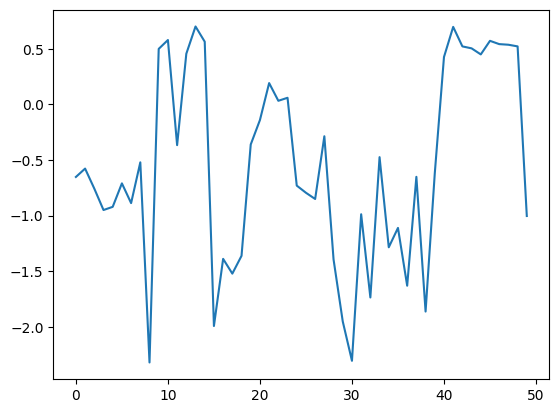

In [25]:
with open('dataset.txt') as f:
  txt = f.readlines()
model = LSTMMemory(15)
data_pts = []
times = []
vels = []

for pt in txt:
  time, vel = pt.split(' ')
  time = log(float(time))
  vel = float(vel[:-2])
  data_pts.append([time, vel])
  times.append(time)
  vels.append(vel)

times = times[::-1]
scaled_vels = preprocessing.scale(vels[::-1])
scaled_vels2 = model.fit_transform(np.array(vels).reshape(len(vels), 1))
data_pts_np = np.array(data_pts[::-1])

print("TIMES")
plt.figure()
plt.plot(times[:50])
plt.show()
print("VELS")
plt.figure()
plt.plot(scaled_vels[:50])
plt.show()

## Training with velocity and time since last note

Loss = 0.06439318507909775 but why do I care?
Loss = 0.0677679032087326 but why do I care?
Loss = 0.06728123128414154 but why do I care?
Loss = 0.06552792340517044 but why do I care?
Loss = 0.05481675639748573 but why do I care?
Loss = 0.07798242568969727 but why do I care?
Loss = 0.07820380479097366 but why do I care?
Loss = 0.0492742545902729 but why do I care?
Loss = 0.06909488141536713 but why do I care?
Loss = 0.065297931432724 but why do I care?


IndexError: too many indices for tensor of dimension 1

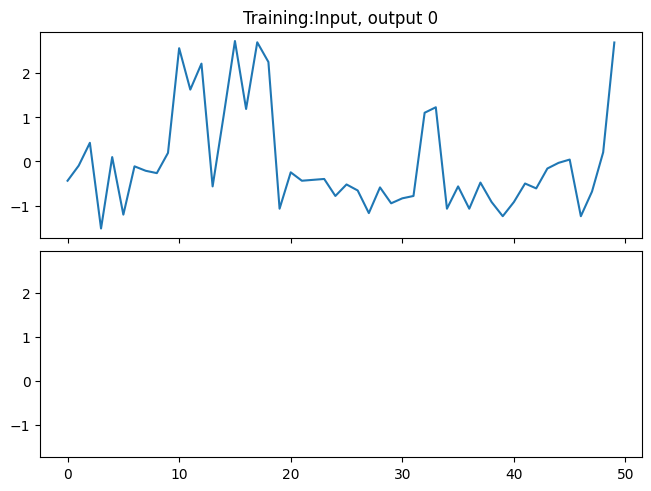

In [19]:
random.seed(39)
torch.manual_seed(42)

model_2d = LSTMMemory(15, 2, 1)
scaled_data = torch.tensor(model_2d.fit_transform(preprocessing.scale(data_pts_np)))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

y_list = random_sine(50)
for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 49:
    print(f"Loss = {loss} but why do I care?")
model.eval()

y_tensor = torch.tensor(y_list)
curve_plot(2, 1, X, y_tensor, f"Training:")

for i in range(4):
  with torch.no_grad():
    test_X = scaled_data[(i + 1) * 50:(i + 2) * 50].reshape(1, 50, 2).float()
    test_predicted_y = model_2d(test_X)

  curve_plot(2, 1, test_X, test_predicted_y, "Testing:")

## velocity and time since last note to m outputs

Loss = 0.12508834898471832
Loss = 0.09715933352708817
Loss = 0.09907004982233047
Loss = 0.08603540062904358
Loss = 0.06303165853023529
Loss = 0.10711415112018585
Loss = 0.08507604897022247
Loss = 0.0692514032125473
Loss = 0.09356673061847687
Loss = 0.0502740815281868
Blue inputs, orange outputs


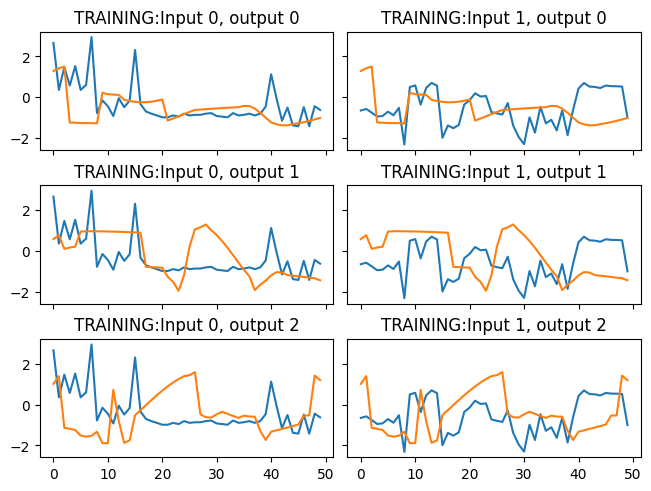

Blue inputs, orange outputs


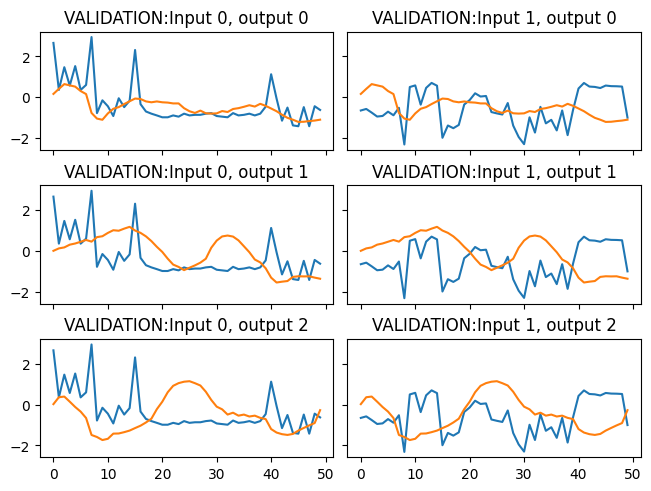

Blue inputs, orange outputs


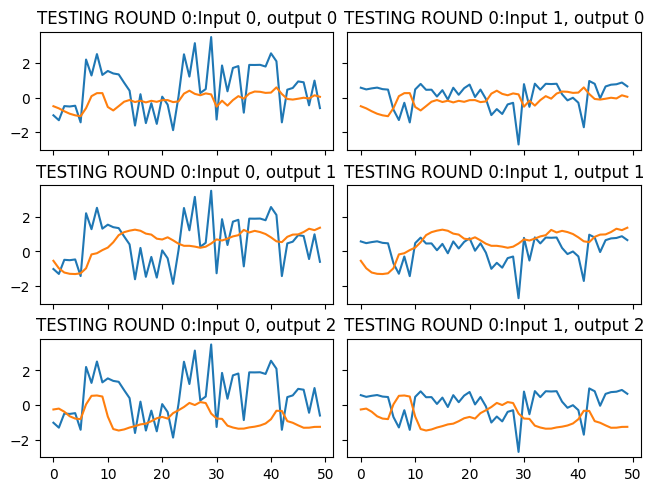

Blue inputs, orange outputs


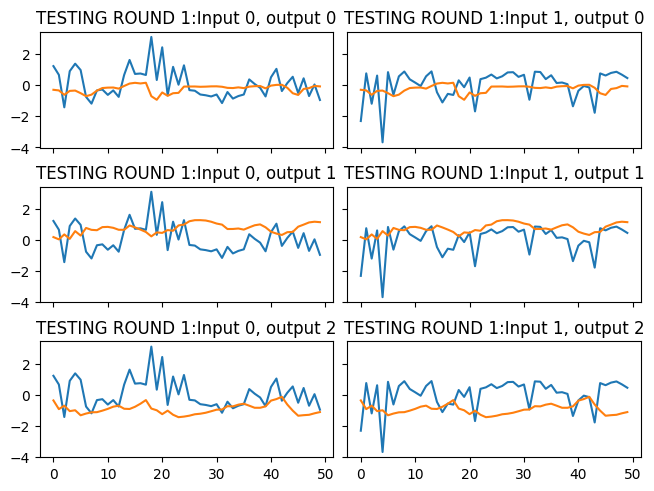

Blue inputs, orange outputs


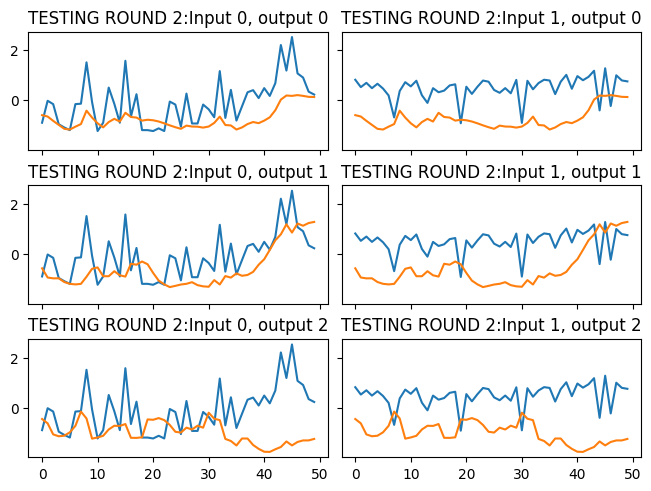

Blue inputs, orange outputs


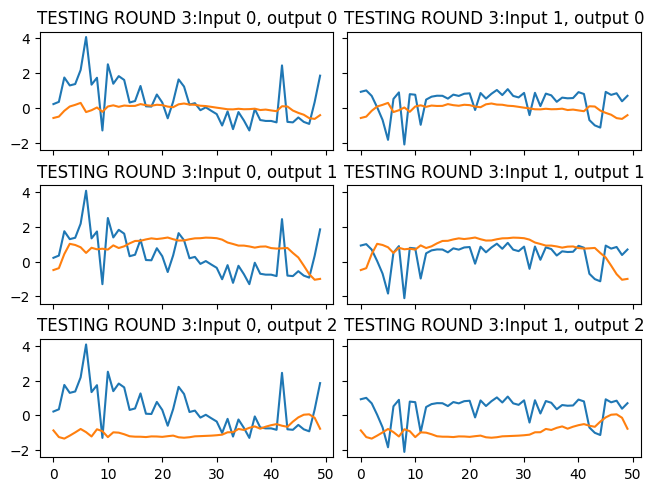

In [67]:
random.seed(1)
torch.manual_seed(42)

outputs = 3

model_2d = LSTMMemory(15, 2, outputs)
scaled_data = torch.tensor(model_2d.fit_transform(data_pts_np))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

y_lists = [random_sine(50, max_freq=5 + i * 3, ) for i in range(outputs)]

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())

  y_lists_permuted = list(zip(*[permute_signal(y) for y in y_lists]))
  y = torch.tensor([y_lists_permuted for _ in range(6)]).reshape((6, 50, outputs))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 49:
    print(f"Loss = {loss}")
model.eval()

y_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, y_tensor * 2, prefix="TRAINING:")

curve_plot(outputs, 2, X, model_2d(X.float()) * 2, prefix="VALIDATION:")

for i in range(4):
  with torch.no_grad():
    test_X = scaled_data[(i + 1) * 50:(i + 2) * 50].reshape(1, 50, 2).float()
    test_predicted_y = model_2d(test_X)
  curve_plot(outputs, 2, test_X, test_predicted_y * 2, prefix=f"TESTING ROUND {i}:")

In [36]:
t1 = torch.Tensor([1, 2, 3])
t2 = torch.Tensor([4, 5, 6])
torch.stack([t1, t2], dim = -1)

tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])

## velocity and time to multiple models

In [52]:
data_pts_np.shape

(490, 2)

Loss for model 0 = 0.06304376572370529
Loss for model 1 = 0.18827885389328003
Loss for model 2 = 0.07850965857505798
Loss for model 0 = 0.048824191093444824
Loss for model 1 = 0.08380848169326782
Loss for model 2 = 0.05901360884308815
Loss for model 0 = 0.0598524808883667
Loss for model 1 = 0.06878918409347534
Loss for model 2 = 0.06498485058546066
Loss for model 0 = 0.04000416025519371
Loss for model 1 = 0.121137835085392
Loss for model 2 = 0.08154430240392685
Loss for model 0 = 0.03514290973544121
Loss for model 1 = 0.13038326799869537
Loss for model 2 = 0.05728733167052269
Loss for model 0 = 0.06399130821228027
Loss for model 1 = 0.09504654258489609
Loss for model 2 = 0.0579407773911953
Loss for model 0 = 0.06405306607484818
Loss for model 1 = 0.06436814367771149
Loss for model 2 = 0.06210713088512421
Loss for model 0 = 0.0446978434920311
Loss for model 1 = 0.036729827523231506
Loss for model 2 = 0.07056063413619995
Loss for model 0 = 0.0355968214571476
Loss for model 1 = 0.14084726

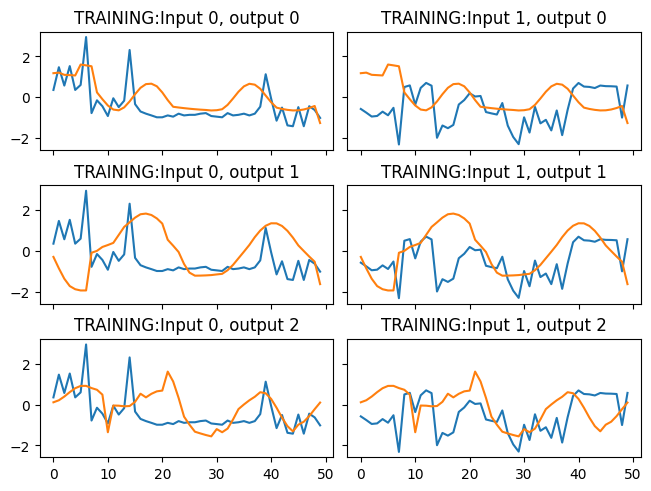

Blue inputs, orange outputs


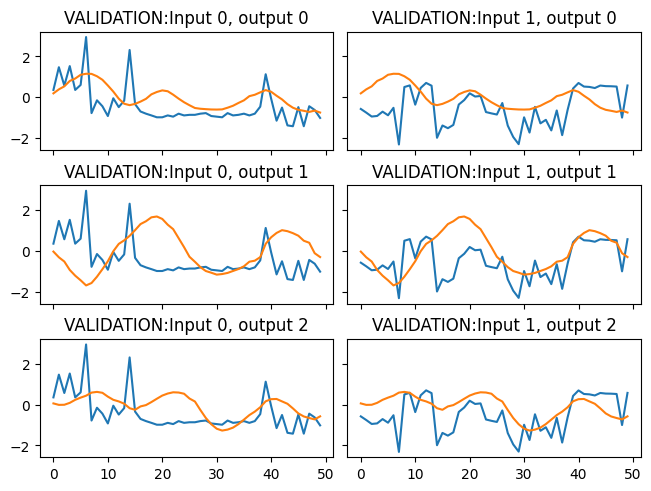

Blue inputs, orange outputs


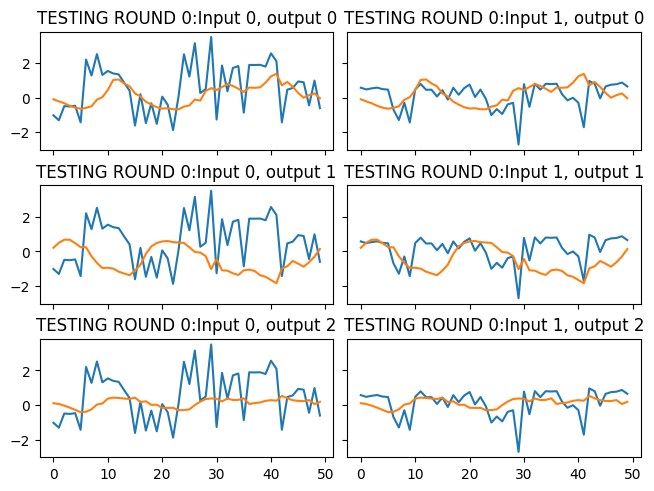

Blue inputs, orange outputs


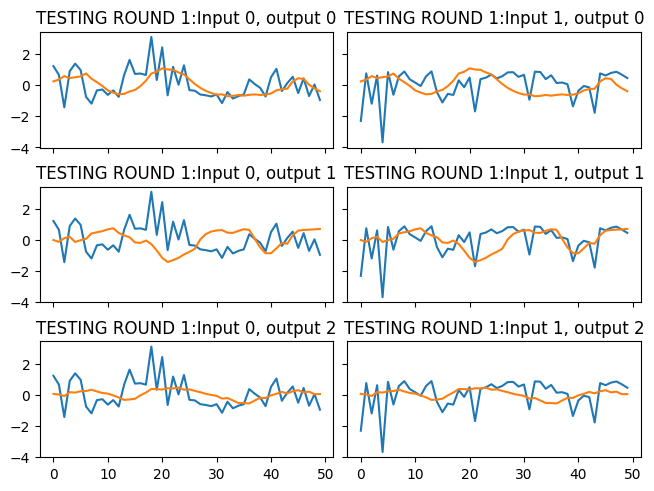

Blue inputs, orange outputs


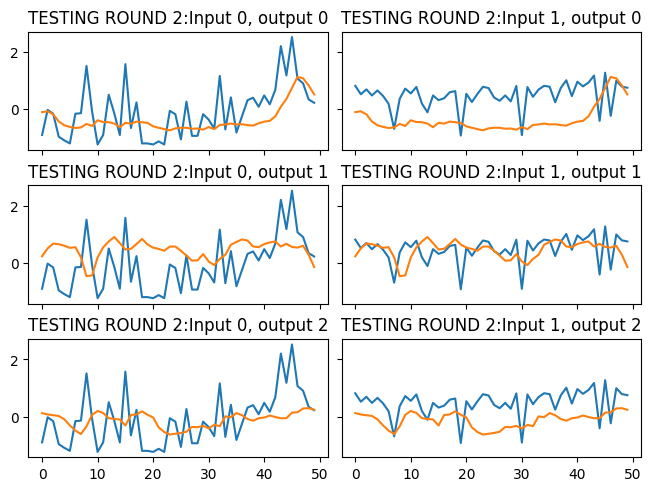

Blue inputs, orange outputs


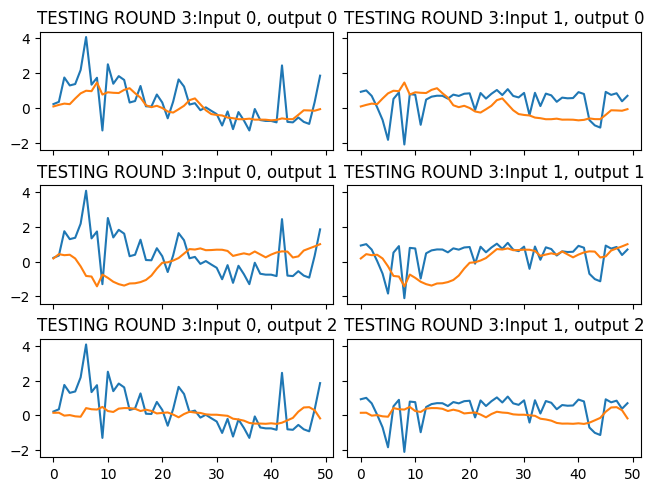

In [71]:
random.seed(21)
torch.manual_seed(42)

outputs = 3

models = [LSTMMemory(25, 2, 1) for _ in range(outputs)]

for model in models:
  model.fit(data_pts_np)
scaled_data = torch.tensor(models[0].transform(data_pts_np))
X_row = scaled_data[1:51]
X = X_row.repeat(6, 1, 1)

y_lists = [random_sine(50) for _ in range(outputs)]

criterion = torch.nn.MSELoss()
optimizers = [torch.optim.RMSprop(model.parameters(), lr=.02) for model in models]
for model in models:
    model.train()

for j in range(500):
  for i in range(outputs):
    optimizers[i].zero_grad()
    pred = models[i](X.float())

    y = torch.tensor([permute_signal(y_lists[i]) for _ in range(6)]).reshape(6, 50, 1)

    loss = criterion(pred, y)
    loss.backward()
    optimizers[i].step()

    if j % 50 == 49:
      print(f"Loss for model {i} = {loss}")

for model in models:
    model.eval()

y_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, y_tensor * 2, prefix="TRAINING:")

valid_list = [model(X.float())[0] for model in models]
validation_out = torch.stack(valid_list, dim=-1).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, validation_out * 2, prefix="VALIDATION:")

for i in range(4):
  with torch.no_grad():
    test_X = scaled_data[(i + 1) * 50 :(i + 2) * 50].reshape(1, 50, 2).float()
    test_predicted_y = torch.stack([model(test_X) for model in models], dim=-1).reshape(1, 50, outputs)
  curve_plot(outputs, 2, test_X, test_predicted_y * 2, prefix=f"TESTING ROUND {i}:")

In [43]:
torch.stack(valid_list, dim=-1).shape

torch.Size([6, 50, 1, 2])

### Saving

In [ ]:
torch.save(model_2d, "/content/drive/MyDrive/rnn_improv/vel_time1.pt")

# Testing for live usage

In [ ]:
live_outputs = []
test_live_X = torch.tensor(vels[200:250]).reshape((1, 50, 1)).float()

with torch.no_grad():
  model.reset_live()
  for i in range(50):
    live_out = model.forward_live(test_live_X[:, i, :])
    live_outputs.append(live_out.item())

plt.plot(live_outputs)



In [ ]:
live_outputs = []
test_live_X = torch.tensor(vels[200:250]).reshape((1, 50, 1)).float()

with torch.no_grad():
  model.reset_live()
  for i in range(50):
    live_out = model.forward_live(torch.tensor([random.uniform(0, 1)]).reshape(1, 1))
    live_outputs.append(live_out.item())

plt.plot(live_outputs)

In [ ]:
test_live_X[:, 1, :]

In [ ]:
torch.rand((1, 1, 1))